In [1]:
from anndata import AnnData
import scanpy as sc
import squidpy as sq
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

from sklearn.cluster import KMeans

In [2]:
seed = 0
np.random.seed(seed)
random.seed(seed)

In [3]:
colors = {"DCT": "#800515",
               "IC/DCT": "#bd5713",
               "Endothelium": "#63ad2d", 
               "PC": "#a4b507",
               "Immune": "black",
               "Podo": "#6e640e", 
               "Fibro": "#1c768a",
               "VSMC/Mes": "#3e9c72",
               "PT": "#448efc",
               "PT?": "#51657a", 
               "iPT": "#6f37b3",
               "PEC": "#ff0011",
               "TAL": "#b44dbf",
               "Injured TAL": "#e3126d",
         }

In [4]:
adata = sc.read_h5ad("/home/levinsj/spatial/adata/7_13_23_slide0_annotated.h5ad")

In [5]:
adata.obs["cellType_CosMx_1"].value_counts()

cellType_CosMx_1
PT             167722
TAL             75458
Fibro           70389
Endothelium     52335
Immune          40993
PC              37993
IC/DCT          25426
Injured TAL     24028
DCT             22763
iPT             18183
Podo             8920
VSMC/Mes         8636
PEC              5755
Name: count, dtype: int64

In [6]:
sq.gr.spatial_neighbors(
    adata,
    radius=0.02,
    coord_type="generic",
    key_added = "20_micron"
)

# 20 micron neighborhood

  0%|          | 0/1000 [00:00<?, ?/s]

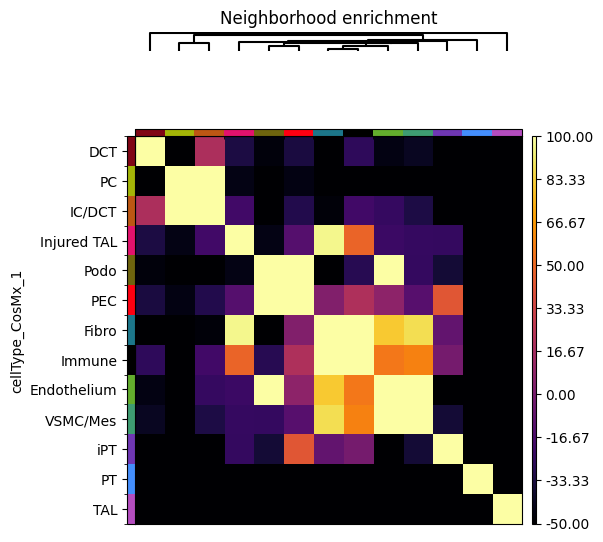

In [7]:

sq.gr.nhood_enrichment(adata, cluster_key="cellType_CosMx_1", connectivity_key = "20_micron")
sq.pl.nhood_enrichment(
    adata,
    connectivity_key = "20_micron",
    cluster_key="cellType_CosMx_1",
    method="average",
    cmap="inferno",
    vmin=-50,
    vmax=100,
    figsize=(5, 5),
)

(array([7.0000e+01, 1.9700e+02, 4.5000e+02, 8.7900e+02, 1.6260e+03,
        2.5780e+03, 4.1010e+03, 6.4980e+03, 9.4470e+03, 1.3193e+04,
        1.7695e+04, 2.2715e+04, 2.8504e+04, 3.4608e+04, 4.0214e+04,
        4.5120e+04, 4.8854e+04, 4.9913e+04, 4.9647e+04, 4.6485e+04,
        4.0370e+04, 3.2693e+04, 2.4019e+04, 1.6548e+04, 1.0428e+04,
        5.9320e+03, 3.1100e+03, 1.4710e+03, 7.1600e+02, 2.9700e+02,
        1.3300e+02, 5.0000e+01, 2.9000e+01, 8.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49.]),
 <BarContainer object of 49 artists>)

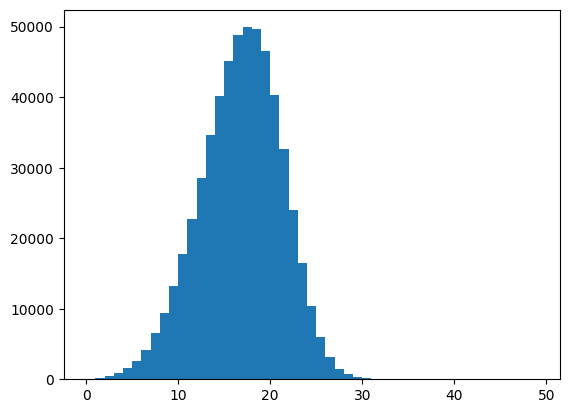

In [8]:
neighbor_check = []
for i in range(adata.obsp["spatial_connectivities"].shape[0]):
  neighbor_check.append(np.sum(adata.obsp["spatial_connectivities"][i]))

# total number of neighbors
plt.hist(neighbor_check, bins = np.arange(0, 50, 1))

In [9]:
df = pd.DataFrame()

for i in adata.obs['cellType_CosMx_1'].unique():
    neighborType = (np.where(adata.obs['cellType_CosMx_1']==i)[0])
    numberNeighbors = pd.DataFrame(adata.obsp["spatial_connectivities"][:, neighborType].sum(axis=1))
    df = pd.concat([df, numberNeighbors], axis=1)

df.columns = adata.obs['cellType_CosMx_1'].unique()
df["index"] = adata.obs.index
df.set_index("index", inplace=True)

Let's look at the elbow to optimize the number of clusters we will check

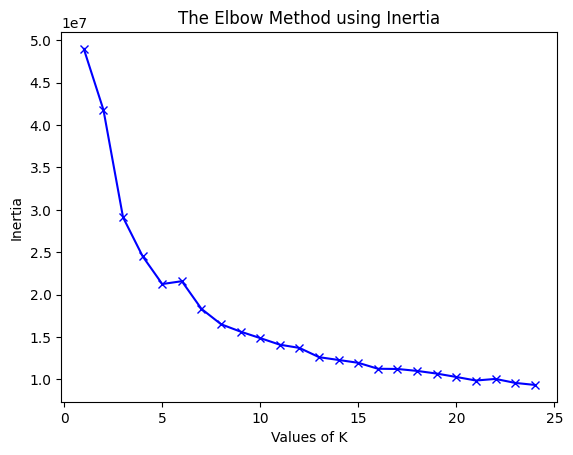

In [10]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

inertias = []
k = range(1, 25)

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for K in k:
    # Create a MiniBatchKMeans object, arbitrarily choosing 10 clusters
    kmeans = MiniBatchKMeans(n_clusters=K)
    # Fit the model to the data
    kmeans.fit(df)
    inertias.append(kmeans.inertia_)

plt.plot(k, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


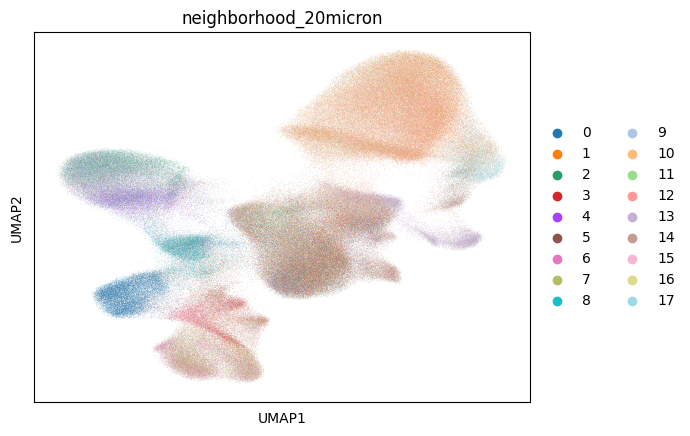

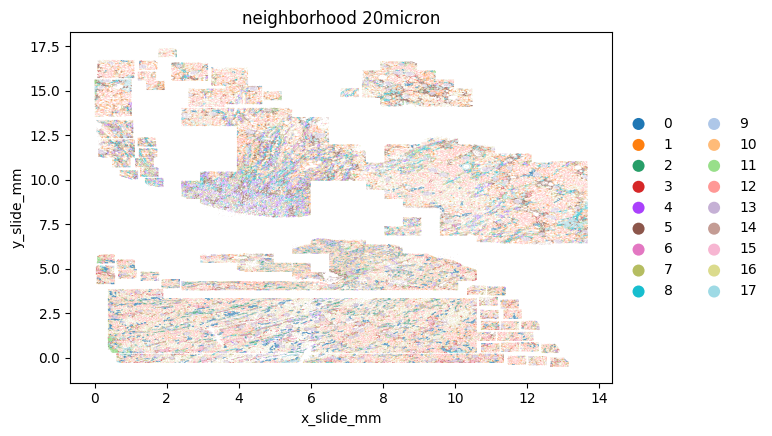

In [11]:
# Create a MiniBatchKMeans object, arbitrarily choosing 10 clusters
kmeans = MiniBatchKMeans(n_clusters=18)

# Fit the model to the data
kmeans.fit(df)

# Predict the cluster labels for each data point
labels = kmeans.predict(df)

adata.obs["neighborhood_20micron"] = labels
adata.obs["neighborhood_20micron"] = adata.obs["neighborhood_20micron"].astype('str')

sc.pl.umap(adata, color = "neighborhood_20micron")

sc.pl.scatter(
    adata,
    x="x_slide_mm",
    y="y_slide_mm",
    color="neighborhood_20micron",
    size=0.2,
)

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.8/dist-packages/scanpy/plot

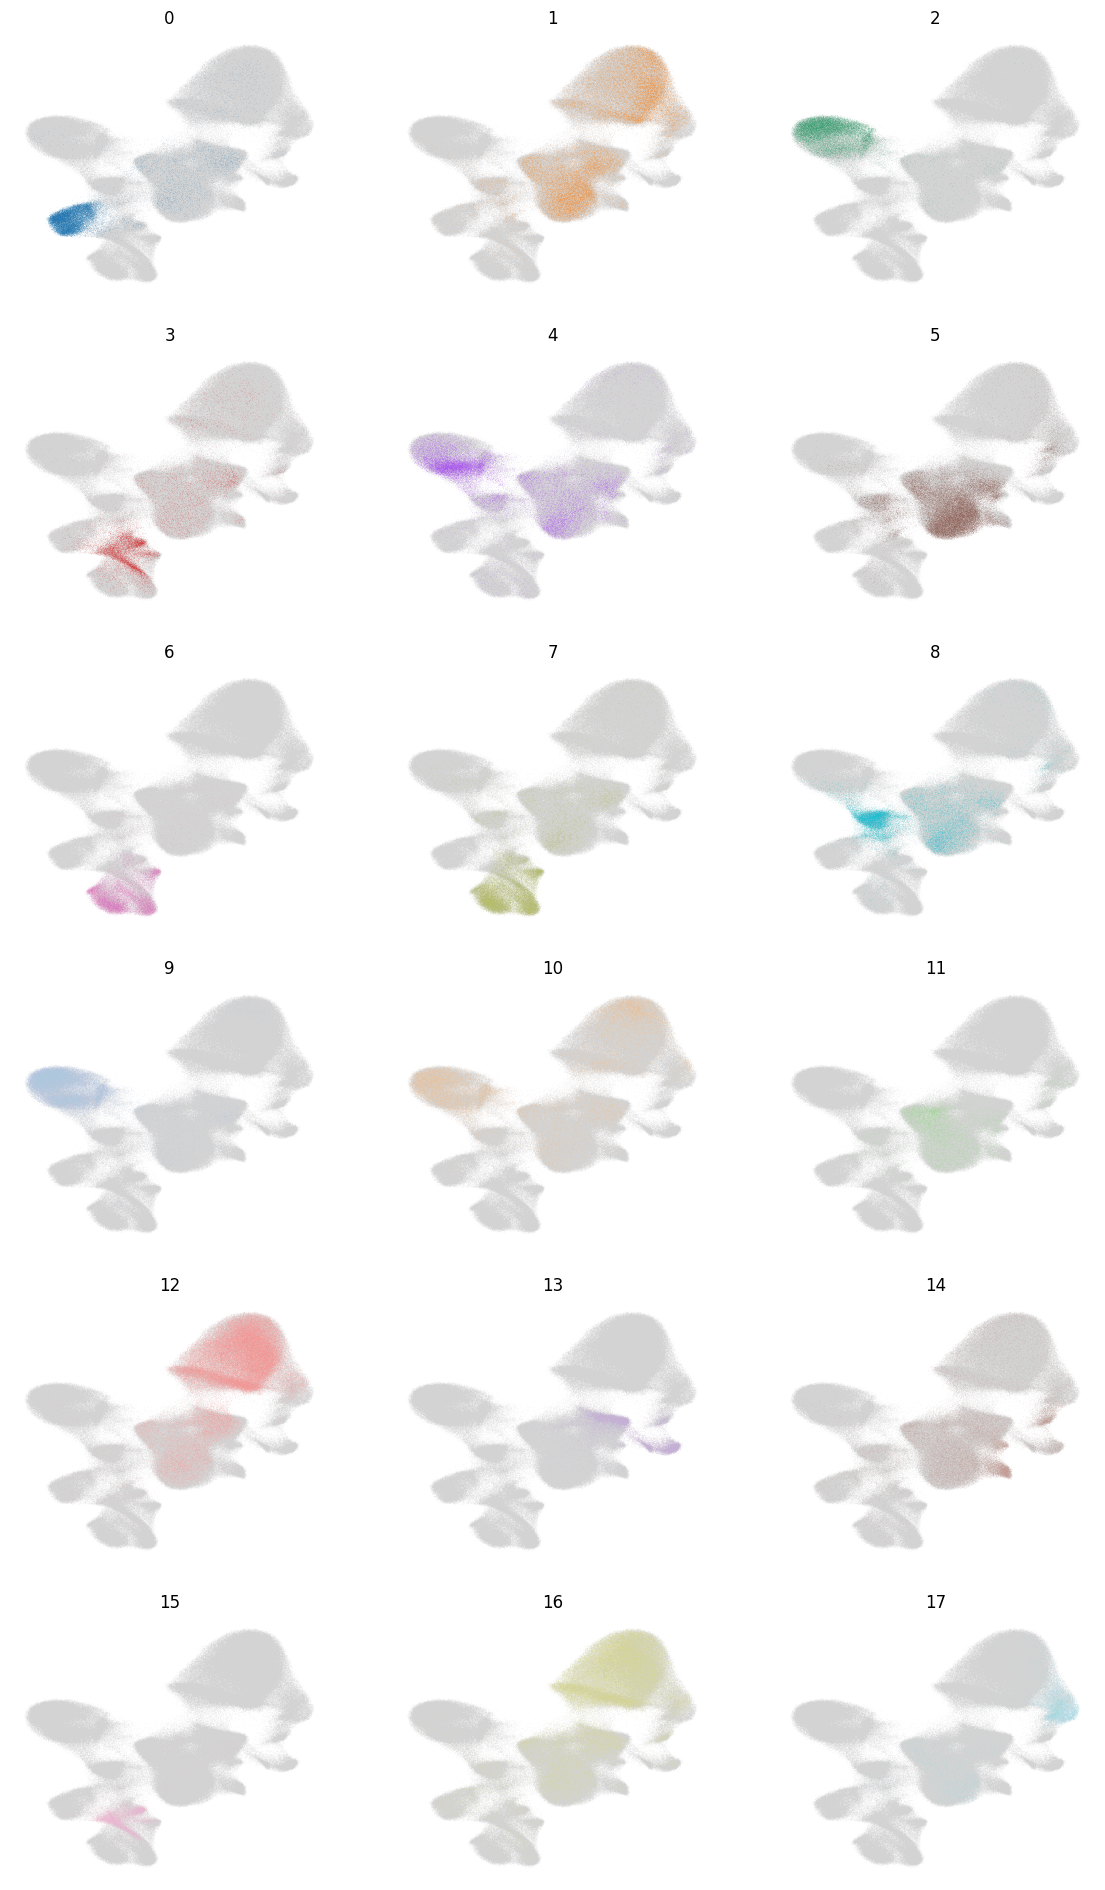

In [12]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(14,24))

sc.pl.umap(adata, color = "neighborhood_20micron", groups = "0",frameon = False, legend_loc = False, title = "0", show = False, ax = axes[0,0])
sc.pl.umap(adata, color = "neighborhood_20micron", groups = "1",frameon = False, legend_loc = False, title = "1", show = False, ax = axes[0,1])
sc.pl.umap(adata, color = "neighborhood_20micron", groups = "2",frameon = False, legend_loc = False, title = "2", show = False, ax = axes[0,2])
sc.pl.umap(adata, color = "neighborhood_20micron", groups = "3",frameon = False, legend_loc = False, title = "3", show = False, ax = axes[1,0])
sc.pl.umap(adata, color = "neighborhood_20micron", groups = "4",frameon = False, legend_loc = False, title = "4", show = False, ax = axes[1,1])
sc.pl.umap(adata, color = "neighborhood_20micron", groups = "5",frameon = False, legend_loc = False, title = "5", show = False, ax = axes[1,2])
sc.pl.umap(adata, color = "neighborhood_20micron", groups = "6",frameon = False, legend_loc = False, title = "6", show = False, ax = axes[2,0])
sc.pl.umap(adata, color = "neighborhood_20micron", groups = "7",frameon = False, legend_loc = False, title = "7", show = False, ax = axes[2,1])
sc.pl.umap(adata, color = "neighborhood_20micron", groups = "8",frameon = False, legend_loc = False, title = "8", show = False, ax = axes[2,2])
sc.pl.umap(adata, color = "neighborhood_20micron", groups = "9",frameon = False, legend_loc = False, title = "9", show = False, ax = axes[3,0])
sc.pl.umap(adata, color = "neighborhood_20micron", groups = "10",frameon = False, legend_loc = False, title = "10", show = False, ax = axes[3,1])
sc.pl.umap(adata, color = "neighborhood_20micron", groups = "11",frameon = False, legend_loc = False, title = "11", show = False, ax = axes[3,2])
sc.pl.umap(adata, color = "neighborhood_20micron", groups = "12",frameon = False, legend_loc = False, title = "12", show = False, ax = axes[4,0])
sc.pl.umap(adata, color = "neighborhood_20micron", groups = "13",frameon = False, legend_loc = False, title = "13", show = False, ax = axes[4,1])
sc.pl.umap(adata, color = "neighborhood_20micron", groups = "14",frameon = False, legend_loc = False, title = "14", show = False, ax = axes[4,2])
sc.pl.umap(adata, color = "neighborhood_20micron", groups = "15",frameon = False, legend_loc = False, title = "15", show = False, ax = axes[5,0])
sc.pl.umap(adata, color = "neighborhood_20micron", groups = "16",frameon = False, legend_loc = False, title = "16", show = False, ax = axes[5,1])
sc.pl.umap(adata, color = "neighborhood_20micron", groups = "17",frameon = False, legend_loc = False, title = "17", show = False, ax = axes[5,2])

plt.axis('off')
plt.show()

16


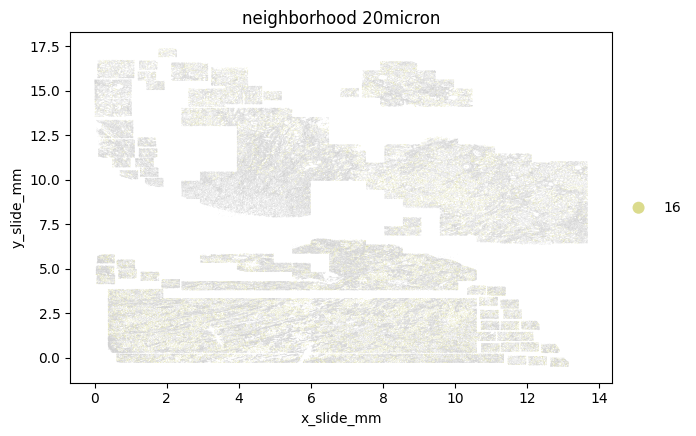

8


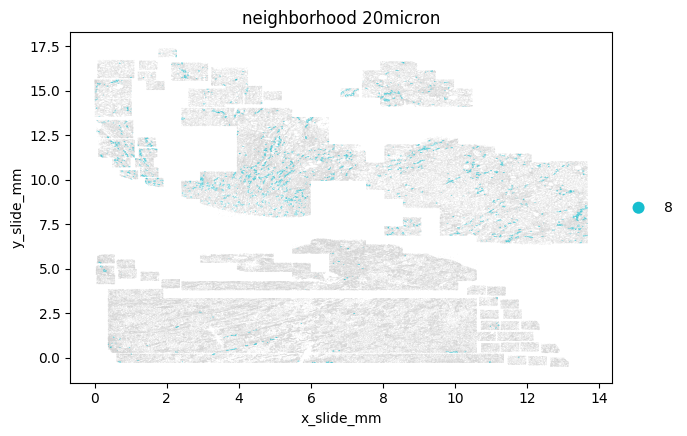

17


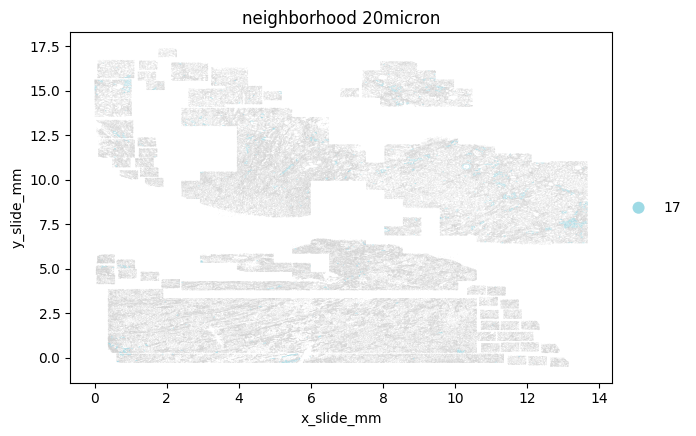

7


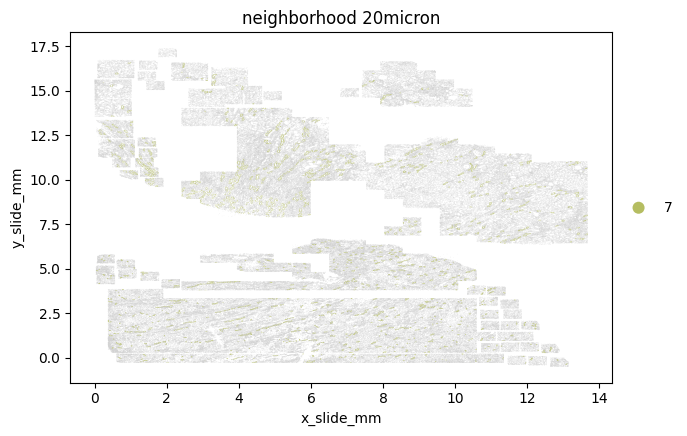

9


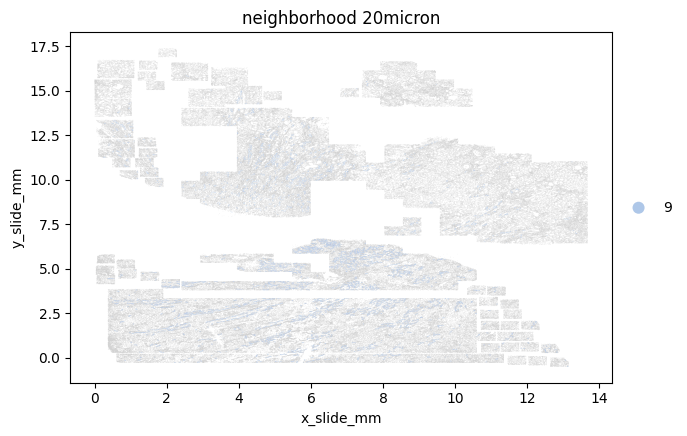

12


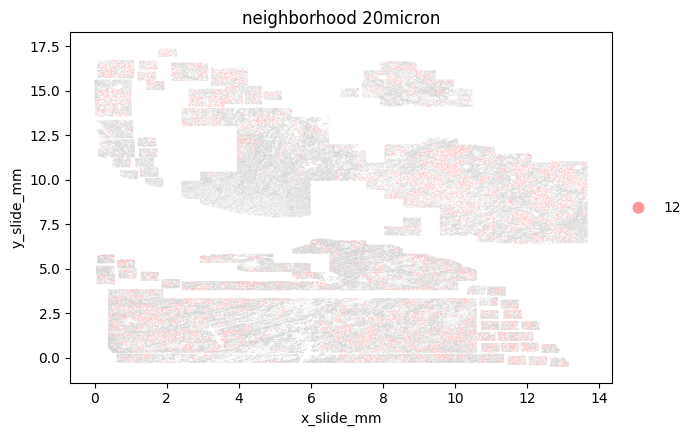

6


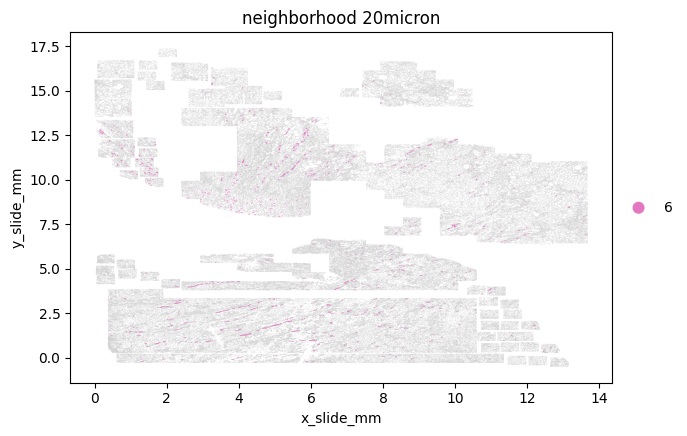

4


2


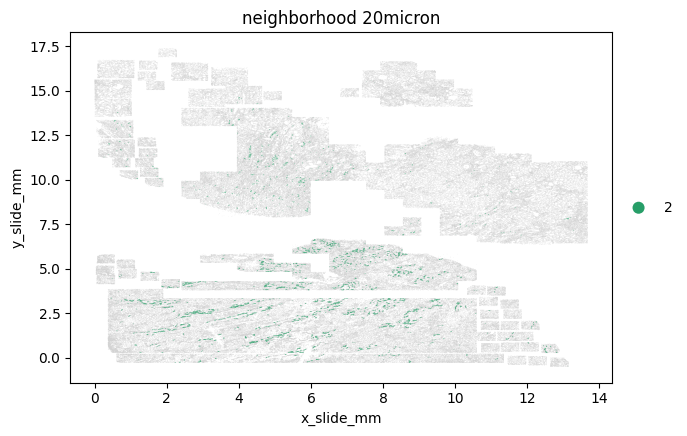

10


1


3


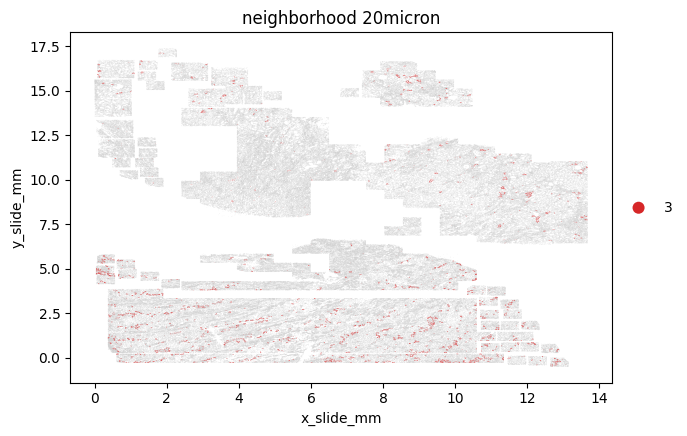

14


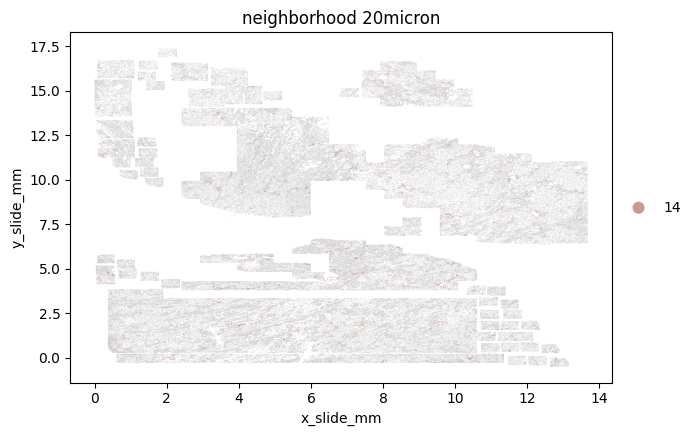

11


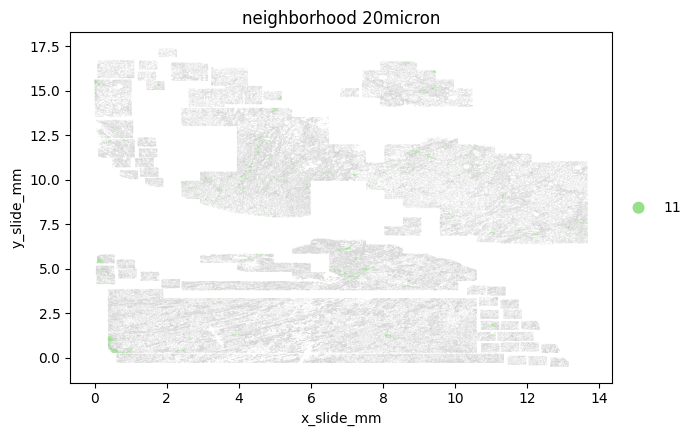

5


13


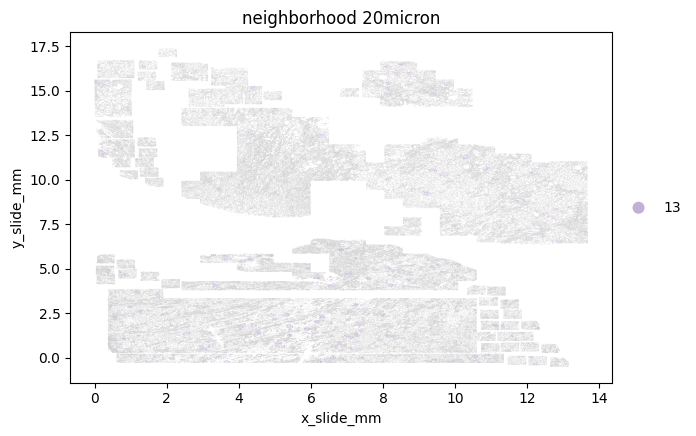

0


15


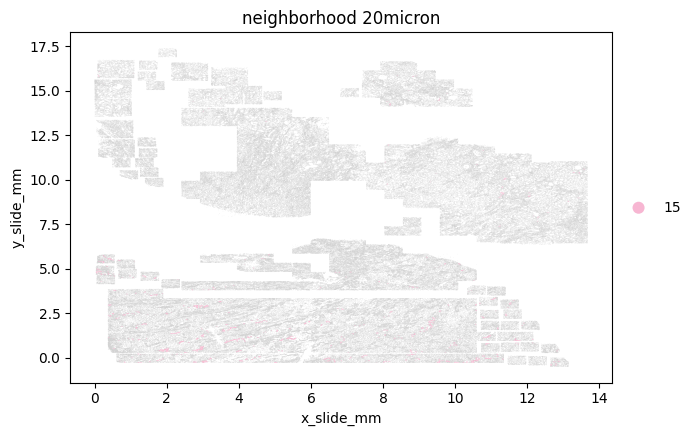

In [13]:
for i in adata.obs["neighborhood_20micron"].unique():
    print(i)
    sc.pl.scatter(
        adata,
        x="x_slide_mm",
        y="y_slide_mm",
        color="neighborhood_20micron",
        size=0.2,
        groups = i
    )

In [14]:
adata.write_h5ad(filename = "/home/levinsj/spatial/adata/7_13_23_slide0_neighborhoodsCalled.h5ad")